In [49]:
import pandas as pd
from sklearn.linear_model import LogisticRegressionCV
from sklearn.cross_validation import train_test_split
import numpy as np
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
from datetime import datetime
%matplotlib inline
from __future__ import print_function

In [2]:
df = pd.read_csv('train.csv', index_col='QuoteNumber', thousands=',', parse_dates=True)

In [3]:
# clean data
df_clean = df.copy()
df_clean['Year'] = pd.to_datetime(df_clean['Original_Quote_Date']).map(lambda x: x.year)
df_clean['Month'] = pd.to_datetime(df_clean['Original_Quote_Date']).map(lambda x: x.month)
df_clean['Month'] = pd.to_datetime(df_clean['Original_Quote_Date']).map(lambda x: x.day)
# remove Original_Quote_Date
df_clean.drop('Original_Quote_Date', axis=1, inplace=True)
df_clean.drop('PropertyField6', axis=1, inplace=True)
df_clean.drop('GeographicField10A', axis=1, inplace=True)

In [4]:
# df_clean.describe()

In [5]:
mapping = {}
for column in df_clean.loc[:, df_clean.dtypes == object]:
    mapping[column] = dict(zip(df_clean[column].unique(),np.arange(len(df_clean[column].unique()))))

df_clean.replace(mapping, inplace=True)

In [6]:
y = df_clean.fillna(-999).iloc[:, 0].values.reshape((df_clean.shape[0]))
X = df_clean.fillna(-999).iloc[:, 1:].values

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [97]:
original_params = {'n_estimators': 2, 'max_depth': 5, 'min_samples_split': 1, 'subsample':1, 'learning_rate': 0.1, 'warm_start':False, 'verbose':1}
train_deviance = np.zeros((6 ,original_params['n_estimators']), dtype=np.float64)
test_deviance = np.zeros((6, original_params['n_estimators']), dtype=np.float64)
for i, (label, color, setting) in enumerate( [('No shrinkage', 'orange',
                               {'learning_rate': 1.0, 'subsample': 1.0}),
                              ('learning_rate=0.1', 'turquoise',
                               {'learning_rate': 0.1, 'subsample': 1.0}),
                              ('subsample=0.8', 'blue',
                               {'learning_rate': 1.0, 'subsample': 0.8}),
                              ('learning_rate=0.1, subsample=1.0', 'yellow',
                               {'learning_rate': 0.1, 'max_features': 0.9}),
                              ('learning_rate=0.1, max_features=2', 'magenta',
                               {'learning_rate': 0.1, 'max_features': 2}),
                              ('learning_rate=0.1, subsample=0.8', 'gray',
                               {'learning_rate': 0.1, 'subsample': 0.8}),] ):
    params = dict(original_params)
    params.update(setting)
    model = ensemble.GradientBoostingClassifier(**params)
    print("Training with parameters: {0} ...".format(label))
    print(params)
    model.fit(X_train, y_train)

    
    train_deviance[i] = model.train_score_
    for j, y_pred in enumerate(model.staged_decision_function(X_test)):
        # clf.loss_ assumes that y_test[i] in {0, 1}
        test_deviance[i][j] = model.loss_(y_test, y_pred)

Training with parameters: No shrinkage ...
{'warm_start': False, 'n_estimators': 2, 'verbose': 1, 'subsample': 1.0, 'min_samples_split': 1, 'learning_rate': 1.0, 'max_depth': 5}
      Iter       Train Loss   Remaining Time 
         1           0.4996           28.28s
         2           0.4233            0.00s
Training with parameters: learning_rate=0.1 ...
{'warm_start': False, 'n_estimators': 2, 'verbose': 1, 'subsample': 1.0, 'min_samples_split': 1, 'learning_rate': 0.1, 'max_depth': 5}
      Iter       Train Loss   Remaining Time 
         1           0.8613           27.59s
         2           0.7947            0.00s
Training with parameters: subsample=0.8 ...
{'warm_start': False, 'n_estimators': 2, 'verbose': 1, 'subsample': 0.8, 'min_samples_split': 1, 'learning_rate': 1.0, 'max_depth': 5}
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.5006           0.4656           24.84s
         2           0.4196           0.0790            0.00s
T

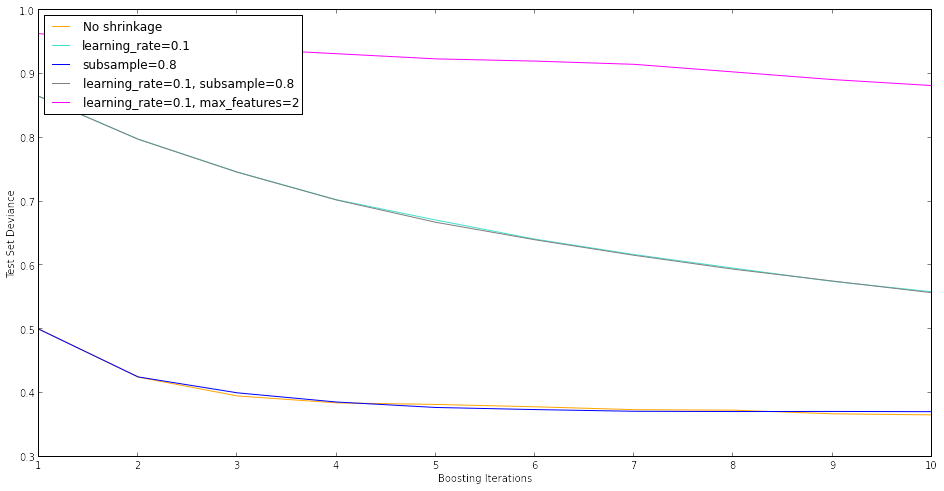

In [86]:
plt.figure(figsize=(16, 8))
plt.plot(np.arange(1, test_deviance.shape[1]+1), test_deviance[0], color='orange', label='No shrinkage')
plt.plot(np.arange(1, test_deviance.shape[1]+1), test_deviance[1], color='turquoise', label='learning_rate=0.1')
plt.plot(np.arange(1, test_deviance.shape[1]+1), test_deviance[2], color='blue', label='subsample=0.8')
plt.plot(np.arange(1, test_deviance.shape[1]+1), test_deviance[3], color='gray', label='learning_rate=0.1, subsample=0.8')
plt.plot(np.arange(1, test_deviance.shape[1]+1), test_deviance[4], color='magenta', label='learning_rate=0.1, max_features=2')
# plt.plot(np.arange(train_deviance.shape[0]), train_deviance, color='magenta', label='train')
plt.legend(loc='upper left')
plt.xlabel('Boosting Iterations')
plt.ylabel('Test Set Deviance')
plt.show()

In [87]:
# Save data
test_deviance.tofile('test_deviance.dat')

In [88]:
d = np.fromfile('test_deviance.dat')

In [94]:
test_deviance.shape

(5, 10)

In [95]:
d.reshape(5,10)

array([[ 0.50047302,  0.42496771,  0.39543957,  0.38455953,  0.38211875,
         0.37844255,  0.37393   ,  0.37314068,  0.36744257,  0.36573369],
       [ 0.86519213,  0.79808941,  0.74655341,  0.70310056,  0.6713088 ,
         0.64133766,  0.61714044,  0.59587123,  0.57501175,  0.55883978],
       [ 0.5000034 ,  0.42528771,  0.40031124,  0.38590226,  0.37735611,
         0.37404868,  0.37138868,  0.37096953,  0.37113325,  0.37074293],
       [ 0.86517356,  0.79800204,  0.74621619,  0.70269238,  0.66778748,
         0.64032744,  0.61595969,  0.59418406,  0.57566979,  0.55729122],
       [ 0.963525  ,  0.94951607,  0.940248  ,  0.93209373,  0.92400828,
         0.92049217,  0.91544869,  0.90353817,  0.89154252,  0.88214383]])